In [1]:
import numpy as np
import os, sys

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels

# training a 10 neuron model for a 3d manifold. 

size of the training set is 2000
torch.Size([2000, 10])
size of the training set is 2000


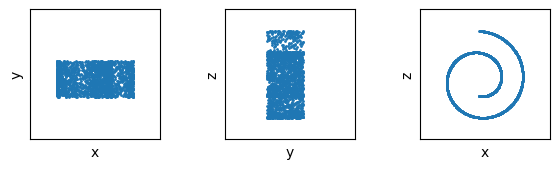

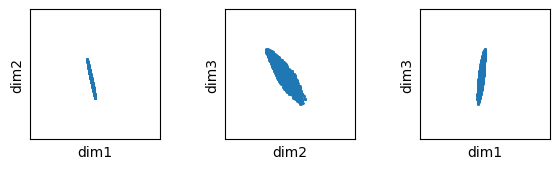

In [2]:
# dataset
from dataset_utils import load_unimodal_data_nd

n_points = int(2e3)

# 2D dataset (not rotated)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
print(dataset.shape)

lim=1.5
lims=[-lim, lim]
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='y', ylabel='z')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='z')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)


# rotated dataset
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim2')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim2', ylabel='dim3')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim3')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)

(2000, 2)
[0.49602692 0.41288775]
[27.28327324 24.89200333]
[[-0.03287562  0.13222172 -0.00297528 -0.52539045  0.56785986  0.09553239
  -0.09798989  0.00944954  0.22629632  0.55937468]
 [-0.06915537  0.30845098 -0.35994248 -0.1960903   0.44076201  0.02786053
  -0.17127983 -0.18515333 -0.26630294 -0.63441499]]


[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

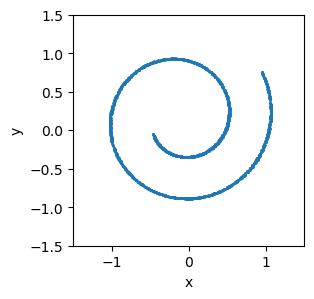

In [3]:
# performing PCA on the rotated dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dataset)
dataset_2d =pca.transform(dataset)
print(dataset_2d.shape)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

# plotting the PCA
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(*dataset_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

this is what we want the generated samples to look like.

In [ ]:
# now train model on the 10D dataset
from prior_utils import forward_process
from utils import noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, 
                    model_name, 
                    model_number, 
                    num_steps, 
                    num_hidden, 
                    num_dims,
                    num_epochs,
                    batch_size,
                    lr,
                    device,
                    dataset,
                    pretrained_model):
    
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
    tb = SummaryWriter(run_dir)
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model

In [ ]:
import json
from models import VariableDendriticCircuit

# define hyperparameter values
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# -------------------------- set model parameters -------------------------- #
model_name = 'unconditional-dendritic'
model_number = 57
num_steps = 100
num_hidden = [3, 3, 3, 3, 3, 3, 4]
num_ambient_dims = 10
num_samples_in_training_set = 1e3
epochs = 3e5
manifold_type = 'swiss_roll_3d'
batch_size = 128
lr = 3e-4
pretrained_model = {
    'use_pretrained_model_weights': True,
    'model_name': 'unconditional-dendritic',
    'model_num': 56
}


# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_number': model_number,
    'num_steps': num_steps,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_samples_in_training_set': f'{num_samples_in_training_set:.0e}',
    'num_epochs': f'{epochs:.0e}',
    'manifold_type': manifold_type,
    'batch_size': batch_size,
    'learning_rate': f'{lr:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']

json_savedir = os.path.join(base_dir, 'core/model_description')
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)


from models import VariableDendriticCircuit
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

Using device: cuda
size of the training set is 2000
taking weights from pretrained model unconditional-dendritic_56!
model loaded!


Training model:   0%|          | 0/300000 [00:00<?, ?epochs/s]

Using device: cpu
model loaded!
size of the training set is 2000
torch.Size([101, 1000, 10])


[(-1.5, 1.5), (-1.5, 1.5), None]

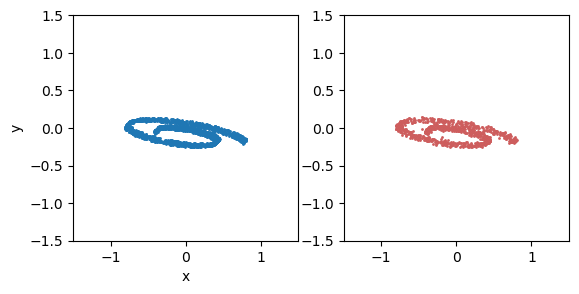

In [4]:
# compare the model output vs ground truth dataset
dim1 = 4
dim2 = 7

# load model and weights
global device
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

from utils import select_model
model, num_steps, dim_amb = select_model('unconditional-dendritic', 58)
model = model.to(device)

dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*dataset[:, (dim1, dim2)].T, s=1)
ax[0].set(xlim=lims, ylim=lims, aspect='equal')
ax[0].set(xlabel='x', ylabel='y')

from prior_utils import p_sample_loop
sample_size = int(1e3)
x_seq = p_sample_loop(model, (sample_size, dim_amb), 100, device=device, init_x=None, normalized_beta_schedule=False)
print(x_seq.shape)


cur_x = x_seq[100].detach().cpu()
ax[1].scatter(cur_x[:, dim1], cur_x[:, dim2],color='white',edgecolor='indianred', s=1)
ax[1].set(xlim=lims, ylim=lims, aspect='equal')


(1000, 2)


[(-1.5, 1.5), (-1.5, 1.5), None]

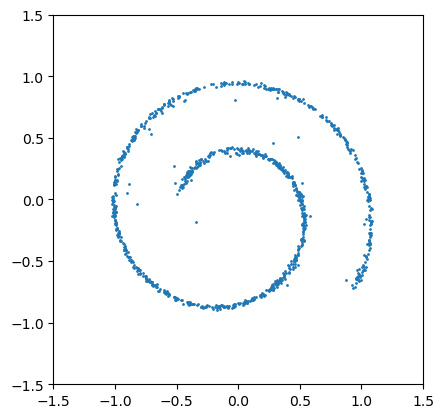

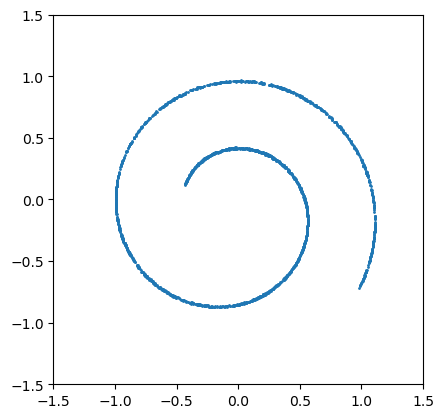

In [5]:
# now perform PCA on the model output
model_output = x_seq[100].detach().cpu()

pca = PCA(n_components=2)
pca.fit(model_output)
x_seq_2d = pca.transform(model_output)
print(x_seq_2d.shape)
eigvalues = pca.components_

fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')


dataset_2d = (eigvalues @ dataset.detach().cpu().numpy().T).T
fig, ax = plt.subplots(1, 1)
ax.scatter(*dataset_2d.T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')


OR I could just calculate the "ground truth" eigenvalues by rotating the basis vectors in the ambient space by the same angles as the dataset

(2, 10)
size of the training set is 2000
(2000, 10)
(2, 2000)
(100,)
(2, 10, 100)


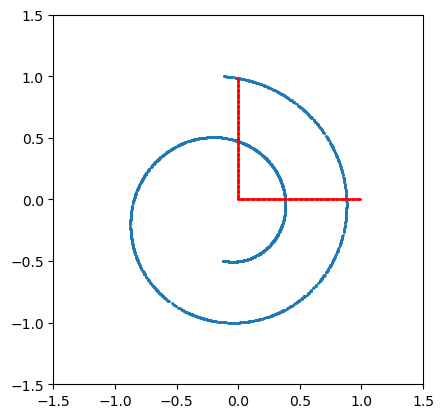

In [6]:
original_basis = np.eye(10)[(0, 2), :]
print(original_basis.shape)

dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
dataset = dataset.detach().cpu().numpy()
print(dataset.shape)
unrotated_dataset = original_basis @ dataset.T
print(unrotated_dataset.shape)

fig, ax = plt.subplots(1, 1)
ax.set(aspect='equal', xlim=lims, ylim=lims)
ax.scatter(*unrotated_dataset, s=1)

ls = np.arange(0, 1, 0.01)
print(ls.shape)
basis_vectors = np.tensordot(original_basis, ls, axes=0)
print(basis_vectors.shape)

ax.scatter(basis_vectors[0, 0, :], basis_vectors[1, 0, :], color='red', s=1)
ax.scatter(basis_vectors[0, 2, :], basis_vectors[1, 2, :], color='red', s=1)

(2, 10)
size of the training set is 2000
(2, 2000)
(2, 500)


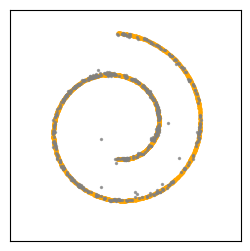

In [32]:
# show the model output during the reverse process, projected onto the 2D basis vectors

# ------------------------ construct the basis vectors ----------------------- #
# rotate the basis vectors by np.pi/4 for each dimension
from dataset_utils import rotate_manifold
n_dims = 10
theta = np.pi/4
rotated_basis = original_basis
# for every axis pair, rotate the vector by angle theta
for i in range(0, n_dims-1):
    for j in range(i+1, n_dims):
        rotated_basis = rotate_manifold(rotated_basis, n_dims, i, j, theta)
rotated_basis = np.array(rotated_basis)
print(rotated_basis.shape)


# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.set(aspect='equal', xlim=lims, ylim=lims)
remove_all_ticks_and_labels(ax)

# project the rotated dataset on the rotated basis vectors
rotated_dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
rotated_dataset = rotated_dataset.detach().cpu().numpy()
projected_rotated_dataset = rotated_basis @ rotated_dataset.T
ax.scatter(*projected_rotated_dataset, s=3, c='orange')

# now project the model output onto these rotated basis vectors
model_output = x_seq[100].detach().cpu().numpy()[:500, :]
projected_model_output = rotated_basis @ model_output.T
print(projected_model_output.shape)
ax.scatter(*projected_model_output, s=2, c='grey', alpha=0.7)

plotting the DM samples during the reverse process, for a 3D manifold

(101, 1000, 10)


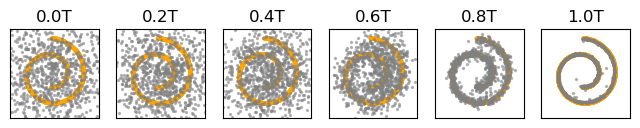

In [8]:
model_output = x_seq.detach().cpu().numpy()
print(model_output.shape)
temps = [0, 20, 40, 60, 80, 100]
fig, ax = plt.subplots(1, len(temps), figsize=(8,3))

for i, t in enumerate(temps):
    projected_model_output = rotated_basis @ model_output[t].T
    ax[i].scatter(*projected_rotated_dataset, s=3, c='orange')
    ax[i].scatter(*projected_model_output, s=2, c='grey', alpha=0.5)
    ax[i].set(aspect='equal', xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
    ax[i].set(title=f'{t/100}T')

In [26]:
# generate samples using neural sampling
# --------------- sample from the prior using neural forward and reverse processes -------------- #
from prior_utils import sequential_prior_sampler
from dataset_utils import load_unimodal_data_nd

# sample_size = int(1e3)
# x_seq = p_sample_loop(model, (sample_size, dim_amb), 100, device=device, init_x=None, normalized_beta_schedule=False)


num_cycles = int(5e2)
# gt_manifold = generate_2d_swiss_roll(int(1e3), True)[1]
swiss_roll_3d = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
init_x = swiss_roll_3d[0].reshape(-1, 10)
seq_x, seq_fwd_x, seq_rev_x = sequential_prior_sampler(model, init_x, num_cycles, normalized_beta_schedule=False)

size of the training set is 2000


  0%|          | 0/500 [00:00<?, ?it/s]

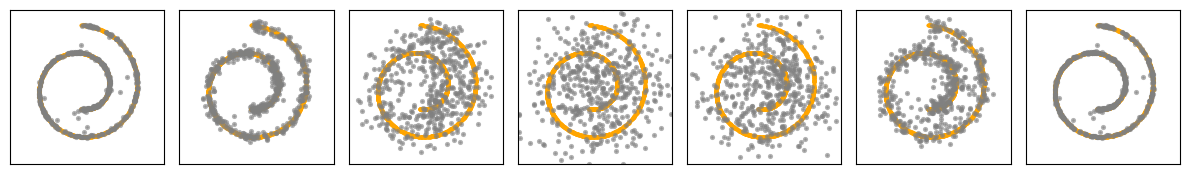

In [77]:
# intermediate steps during the forward/reverse processes
lim = 1.5
lims = [-lim, lim]
swiss_roll_projected = (rotated_basis @ swiss_roll_3d.detach().cpu().numpy().T).T

# Forward process
temps = [0, 25, 50, 100]
fig, axes = plt.subplots(1, len(temps)*2-1, figsize=(12,4))
ax = axes[0:4]
for i, t in enumerate(temps):
    seq_fwd_projected = rotated_basis @ seq_fwd_x[:500,t].T
    ax[i].scatter(*swiss_roll_projected.T, s=3, color='orange')
    ax[i].scatter(*seq_fwd_projected, s=3, lw=2, alpha=0.6, color='grey')
    
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)
    

# Reverse process
ax = axes[4:]
for i, t in enumerate(reversed(temps[:-1])):
    seq_rev_projected = rotated_basis @ seq_rev_x[:500,100-t].T
    ax[i].scatter(*swiss_roll_projected.T, s=3, color='orange')
    ax[i].scatter(*seq_rev_projected, s=3, lw=2, alpha=0.6, color='grey')

for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)

fig.tight_layout()

from plot import save_fig
save_fig(fig, 'figure1A-3d_manifold.png')
    